In [38]:
import numpy as np
import os
import time
import scipy
import glob

from datetime import datetime
import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

import importlib

import pandas as pd
from scipy.stats import binned_statistic_2d
import utils as util
import behavior as butil

In [39]:
importlib.reload(util)

<module 'utils' from '/Users/julianarhee/Repositories/plume-tracking/utils.py'>

In [40]:
util.set_sns_style(style='dark')

## load data

In [41]:
root_dir = '/Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data'
#experiment = 'Spontaneous_edge_tracking'
experiment = 'hdeltac/csv'
# experiment = 'hdeltac'
# 'hdeltac/csv/20220517_hdc_split_60d05_sytgcamp7f'
src_dir = os.path.join(root_dir, experiment)
# src_dir = '/Users/julianarhee/Documents/rutalab/data/test'
print(src_dir)

/Users/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data/hdeltac/csv


In [81]:
log_files = sorted(glob.glob(os.path.join(src_dir, '2022*', 'et', '*.csv')), \
                   key=util.natsort)
#log_files = sorted(glob.glob(os.path.join(src_dir, '*.log')), key=util.natsort)
print("Found {} raw .log behavior files.".format(len(log_files)))

for fi, fpath in enumerate(log_files):
    dfn = fpath.split('/hdeltac/csv/')[1].split('/et')[0]
    print(fi, dfn)

Found 7 raw .log behavior files.
0 20220517_hdc_split_60d05_sytgcamp7f
1 20220627_hdc_split_Fly1
2 20220627_hdc_split_Fly2
3 20220628_HDC_sytjGCaMP7f_Fly1
4 20220628_HDC_sytjGCaMP7f_Fly1_45-004
5 20220629_HDC_split_sytjGCaMP7f_Fly1
6 20220629_HDC_split_sytjGCaMP7f_Fly3


In [75]:
%matplotlib notebook

# plot trajectories

In [78]:
excluded = ['20220628_HDC_sytjGCaMP7f_Fly1_45-004']

<IPython.core.display.Javascript object>


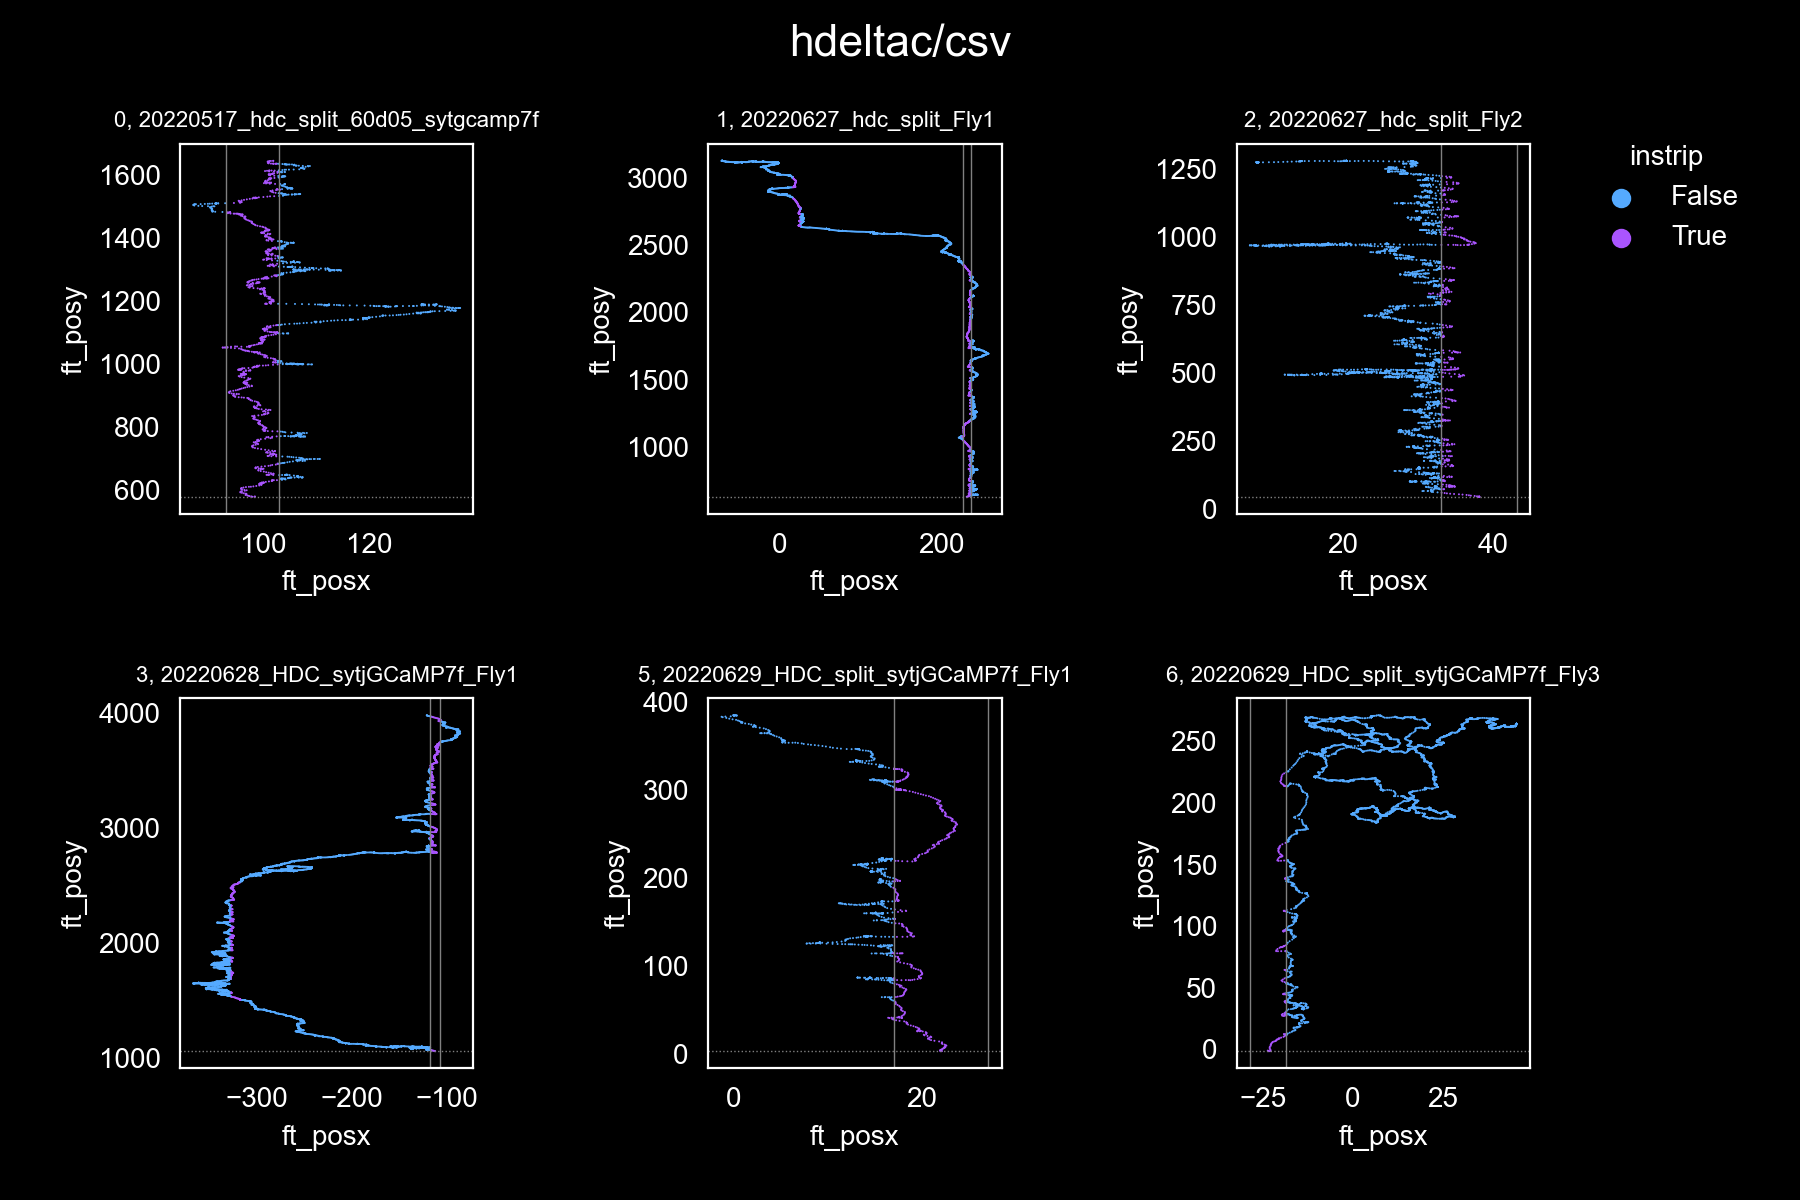

Text(0.5, 0.98, 'hdeltac/csv')

In [82]:
hue_varname='instrip'
palette='cool'
is_csv = True
start_at_odor = True
odor_width=10
odor_lc='lightgray'
odor_lw=0.5
nrows = 2
ncols = 3

xmin, xmax = (-500, 500)
ymin, ymax = (-100, 1000)
odor_xmin, odor_xmax = (-100, 100)
fig, axes = pl.subplots(nrows, ncols, sharex=False, sharey=False, figsize=(ncols*3, nrows*3))
ai = 0
for fi, fpath in enumerate(log_files):
    # load data
    if is_csv:
        df0 = butil.load_dataframe_resampled_csv(fpath)
    else:
        df0 = butil.load_dataframe(fpath) 
    if df0 is None:
        print("error:", fn)
        continue
    #odor params
    odor_params = butil.get_odor_params(df0, odor_width=odor_width)
    odor_xmin, odor_xmax = odor_params['odor_boundary']
    odor_start_posx, odor_start_posy = odor_params['odor_start_pos']
    plotdf = df0[df0['time']>=odor_params['odor_start_time']] if start_at_odor else df0
    # set subplot
    #fn = os.path.splitext(os.path.split(fpath)[-1])[0]
    dfn = fpath.split('/hdeltac/csv/')[1].split('/et')[0]
    if dfn in excluded:
        continue
    title = '{}, {}'.format(fi, dfn)
    ax = axes.flat[ai]
    ax.set_title(title, fontsize=8)
    # plot
    sns.scatterplot(data=plotdf, x='ft_posx', y='ft_posy', hue=hue_varname,
                    palette=palette, s=0.5, ax=ax, linewidth=0, alpha=1) #'none')
    ax.get_legend().remove()
    # add odor corridor
    #butil.center_odor_path(ax, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    butil.plot_odor_corridor(ax, odor_xmin=odor_xmin, odor_xmax=odor_xmax,
                    odor_start_posy=odor_start_posy)
    ai+=1
# remove unused axes
for ix in np.arange(fi+1, nrows*ncols):
    axes.flat[ix].axis('off')
# legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.98, 0.9), ncol=1,
           loc='upper right', title=hue_varname, frameon=False) 
# adjust plots
pl.subplots_adjust(hspace=0.5, wspace=0.8, left=0.1, right=0.85)
fig.suptitle(experiment, fontsize=16)

In [ ]:
#### identify grid

# individual 

In [518]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [519]:
fpath = log_files[3]
dfn = fpath.split('/hdeltac/csv/')[1].split('/et')[0]
print(dfn)
df0 = butil.load_dataframe_resampled_csv(fpath)
# Get odor params 
odor_width =10
odor_params = butil.get_odor_params(df0, odor_width=odor_width)
odor_xmin, odor_xmax = odor_params['odor_boundary']
odor_start_posx, odor_start_posy = odor_params['odor_start_pos']
trial_start_time = odor_params['trial_start_time']
odor_start_time = odor_params['odor_start_time']

20220628_HDC_sytjGCaMP7f_Fly1


In [520]:
# parse in and out bouts
df = butil.parse_bouts(df0, count_varname='instrip', bout_varname='boutnum') # 1-count
# filter in and out bouts by min. duration 
bout_thresh=0.5
df = butil.filter_bouts_by_dur(df, bout_thresh=bout_thresh, bout_varname='boutnum', 
                        count_varname='instrip', verbose=False)
# get durations
# boutdurs_dict = butil.get_bout_durs(df, bout_varname='boutnum')
# check if any too short
too_short = [k for k, v in boutdurs.items() if v<0.5]
too_short

[]

In [521]:
# plot all bouts
# --------------------------------------------------------
start_at_odor=True
hue_varname='boutnum'
nbouts_plot=20
palette='viridis'
#plotdf = df[df['time']>=odor_start_time] if start_at_odor else df.copy()
#plotdf = plotdf[plotdf['boutnum']<=nbouts_plot].copy() #[df0['time']>=odor_start_time].copy()
# --------------------------------------------------------
# fig, ax = pl.subplots(figsize=(8,6))
# sns.scatterplot(data=plotdf, x='ft_posx', y='ft_posy', hue=hue_varname, palette=palette,
#                s=3, ax=ax, edgecolor='none')
# ax.plot(odor_start_posx, odor_start_posy, 'w*', markersize=10) 
# ax.axvline(x=odor_xmin, c=odor_lc, lw=odor_lw) 
# ax.axvline(x=odor_xmax, c=odor_lc, lw=odor_lw) 
# if not start_at_odor:
#     ax.axhline(odor_start_posy, 'w:')
# ax.legend(bbox_to_anchor=(1,1), loc='upper left', title=hue_varname, frameon=False)
# ax.set_title('{}/{}'.format(experiment, fn))

In [534]:
importlib.reload(butil)

<module 'behavior' from '/Users/julianarhee/Repositories/plume-tracking/behavior.py'>

In [535]:
grid_sep=200

ogrid = butil.get_odor_grid(df, odor_width=odor_width, grid_sep=grid_sep,
                           use_crossings=False, verbose=True)
ogrid


{'c1098': (-117.4613954446088, -107.4613954446088),
 'c2804': (-322.38888865304597, -312.38888865304597),
 'c7597': (-116.80678965910519, -106.80678965910519)}

In [536]:
ogrid2 = butil.get_odor_grid(df, odor_width=odor_width, grid_sep=grid_sep,
                           use_crossings=True, verbose=True)
ogrid2

got both
c1098: min -117.46 vs -117.28
c1098: max -107.46 vs -107.17
True diff: 10.11
got both
c2804: min -322.39 vs -327.17
c2804: max -312.39 vs -317.17
True diff: 10.00
got both
c7597: min -116.81 vs -117.31
c7597: max -106.81 vs -107.17
True diff: 10.15


{'c1098': (-117.27972442575403, -107.166057760788),
 'c2804': (-327.1692030306531, -317.16725622282),
 'c7597': (-117.31416827280732, -107.166057760788)}

<IPython.core.display.Javascript object>


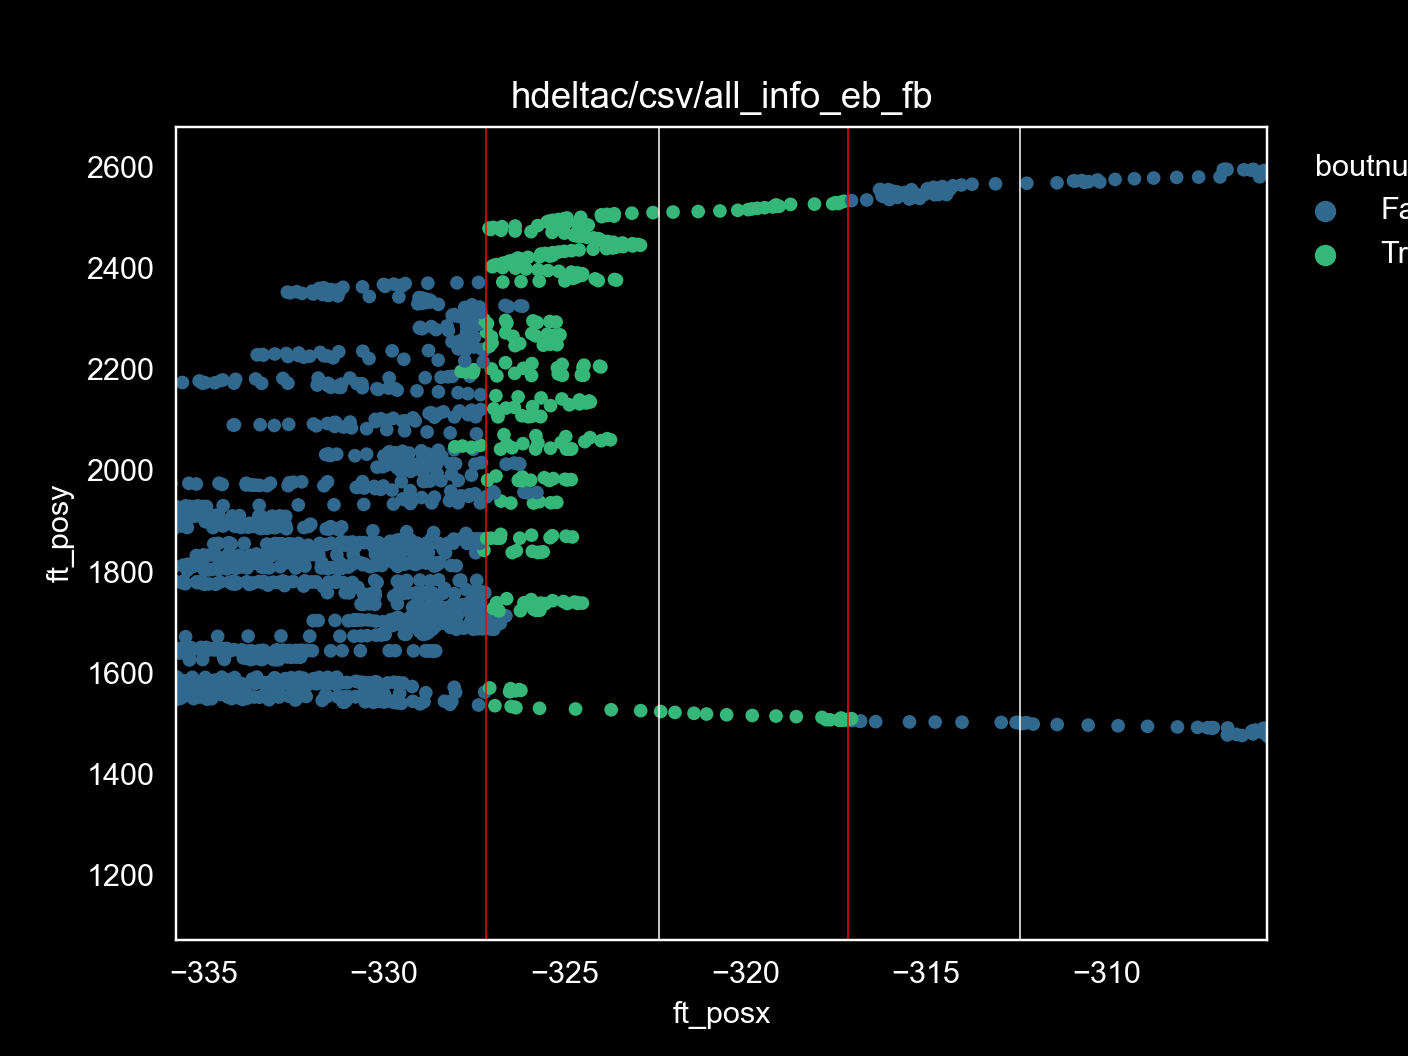

Text(0.5, 1.0, 'hdeltac/csv/all_info_eb_fb')

In [537]:
plotdf = df[df['time']>=odor_start_time]
# --------------------------------------------------------
fig, ax = pl.subplots()
sns.scatterplot(data=plotdf, x='ft_posx', y='ft_posy', hue='instrip', palette=palette,
               s=20, ax=ax, edgecolor='none')
ax.plot(odor_start_posx, odor_start_posy, 'w*', markersize=10) 
for cnum, (odor_xmin, odor_xmax) in ogrid2.items():
    ax.axvline(x=odor_xmin, c='r', lw=odor_lw) 
    ax.axvline(x=odor_xmax, c='r', lw=odor_lw) 
for cnum, (odor_xmin, odor_xmax) in ogrid.items():
    ax.axvline(x=odor_xmin, c='w', lw=odor_lw) 
    ax.axvline(x=odor_xmax, c='w', lw=odor_lw) 
ax.legend(bbox_to_anchor=(1,1), loc='upper left', title=hue_varname, frameon=False)
ax.set_title('{}/{}'.format(experiment, fn))

In [396]:
ogrid

{'c1098': (-117.4613954446088, -107.4613954446088),
 'c2804': (-322.38888865304597, -312.38888865304597),
 'c7597': (-116.80678965910519, -106.80678965910519)}

In [531]:
ix = 2804
curr_odor_xmin, curr_odor_xmax = ogrid['c%i' % ix]
curr_odor_xmin, curr_odor_xmax

(-322.38888865304597, -312.38888865304597)

In [532]:
# get left and right edge crossings
right_xings = df[(df['ft_posx'] <= (curr_odor_xmax+odor_width*.5)) \
               & (df['ft_posx'] >= (curr_odor_xmax-odor_width*.5))].loc[ix:].copy()
left_xings = df[(df['ft_posx'] <= (curr_odor_xmin+odor_width*.5)) \
               & (df['ft_posx'] >= (curr_odor_xmin-odor_width*.5))].loc[ix:].copy()
# get in/out bouts
right_xings = butil.parse_bouts(right_xings, count_varname='instrip')
left_xings = butil.parse_bouts(left_xings, count_varname='instrip')
# get index of each bout's 1st entry
first_in_ixs_left=[]
starts_instrip = left_xings.iloc[0]['instrip']
for bi, (bnum, bdf) in enumerate(left_xings[left_xings['instrip']].groupby('boutnum')):
    if starts_instrip and bi==0: # special case of crossing, get last instri and first outstrip
        in_ix = bdf.sort_values(by='time').iloc[-1].name
        first_in_ixs_left.extend([in_ix, in_ix+1])
        continue
    in_ix = bdf.iloc[0].name
    first_in_ixs_left.extend([in_ix-1, in_ix])
first_in_ixs_right=[]
starts_instrip = right_xings.iloc[0]['instrip']
for bi, (bnum, bdf) in enumerate(right_xings[right_xings['instrip']].groupby('boutnum')):
    if starts_instrip and bi==0: # special case of crossing, get last instri and first outstrip
        in_ix = bdf.sort_values(by='time').iloc[-1].name
        first_in_ixs_right.extend([in_ix, in_ix+1])
        continue
    in_ix = bdf.iloc[0].name
    print(bnum)
    first_in_ixs_right.extend([in_ix-1, in_ix])

<IPython.core.display.Javascript object>


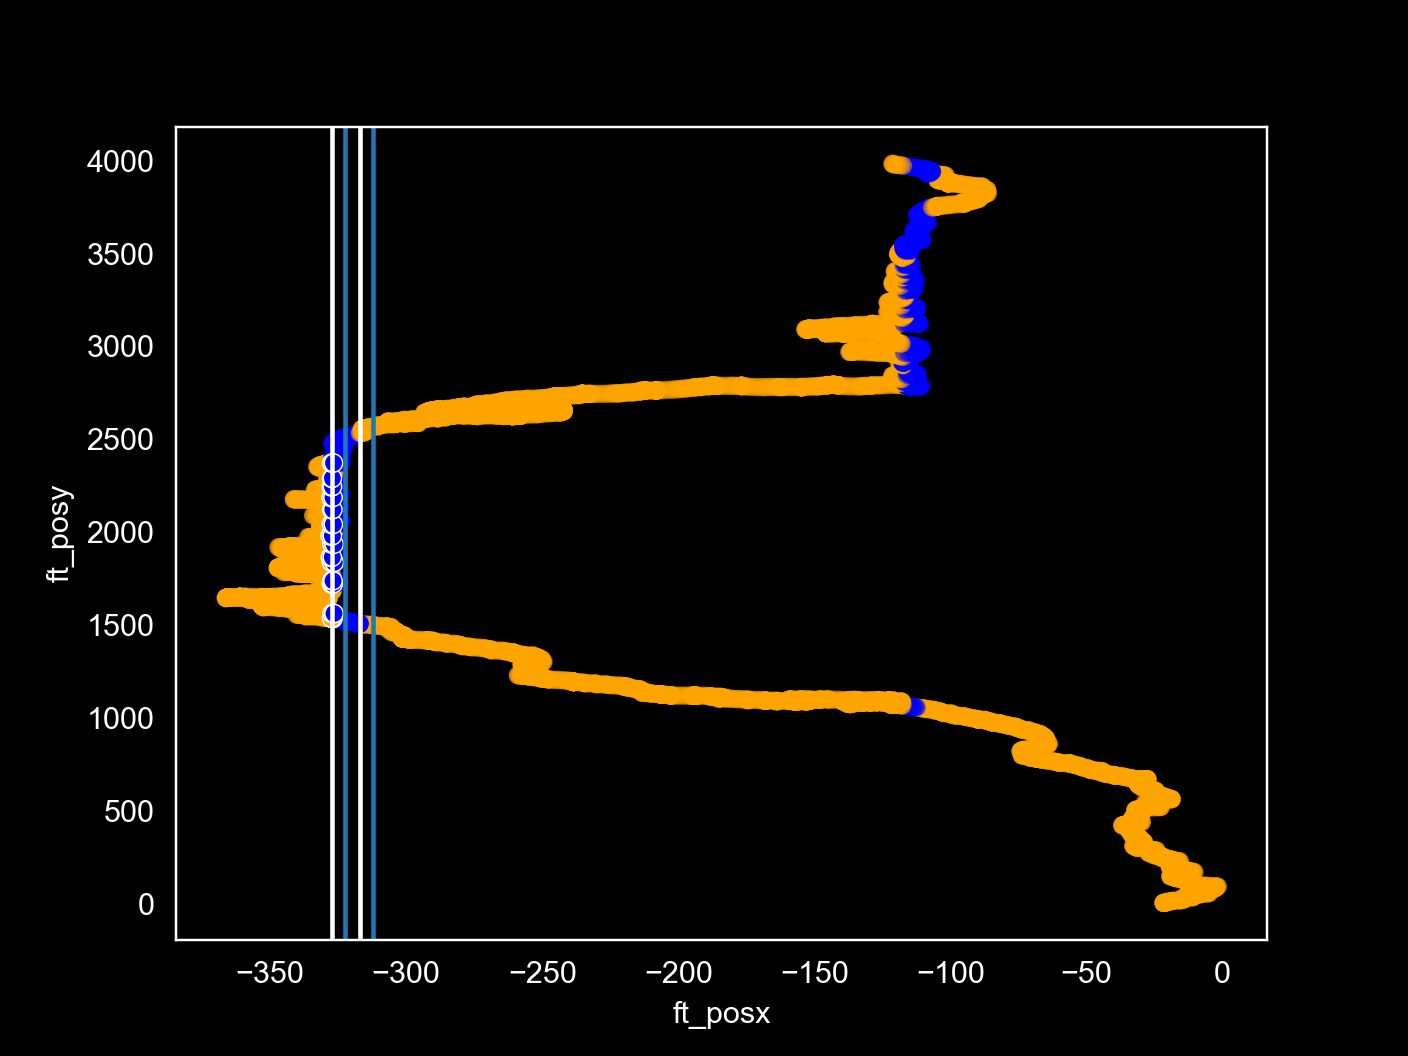

In [533]:
fig, ax = pl.subplots()
sns.scatterplot(data=df, x='ft_posx', y='ft_posy', hue='instrip', ax=ax, alpha=0.5,
               edgecolor='none', palette=['blue', 'orange'], hue_order=[True, False])
sns.scatterplot(data=df.loc[first_in_ixs_left], x='ft_posx', y='ft_posy', hue='instrip', ax=ax,
               edgecolor='white', palette=['blue', 'orange'], hue_order=[True, False])
ax.axvline(x=curr_odor_xmin)
ax.axvline(x=curr_odor_xmax)
e1 = df.loc[first_in_ixs_left]['ft_posx'].mean()
e2 = df.loc[first_in_ixs_right]['ft_posx'].mean()

ax.axvline(x=e1, color='w')
ax.axvline(x=e2, color='w')
ax.legend_.remove()

In [14]:
df["instripX"] = df["instrip"].shift()
df["boutnum"] = (df["instrip"] != df["instripX"]).cumsum()

In [15]:
df['boutnum']

0        1
1        1
2        1
3        1
4        1
        ..
3098    38
3099    38
3100    38
3101    38
3102    38
Name: boutnum, Length: 3103, dtype: int64

In [16]:
boutdurs={}
for boutnum, df_ in df.groupby(['boutnum']):
    boutdur = df_.iloc[-1]['time'] - df_.iloc[0]['time']
    boutdurs.update({boutnum: boutdur})
[k for k, v in boutdurs.items() if v<0.5]

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_54135/470690779.py:2: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



[]

In [17]:
(df0[df0['time']<=odor_start_time]['time'].max() - df0[df0['time']<=odor_start_time]['time'].min())/60.

1.8317541416666547

In [18]:
for k, v in boutdurs.items():
    print(k, v)

1 109.806885900005
2 5.701174500005436
3 6.901919199990516
4 3.401313400005165
5 4.895448899995245
6 5.997935100000177
7 6.704671100000269
8 22.10252230000333
9 9.20333039999241
10 0.5106772000071942
11 0.9950198166625341
12 11.09420659999887
13 0.6065501000048243
14 3.6978459999954794
15 33.40766960000474
16 11.585368700012623
17 14.895709100004751
18 1.1927848500054097
19 6.802942833332054
20 1.4976132000010693
21 1.0986787999936496
22 2.793729099990742
23 0.5011420499940868
24 0.8063229999970645
25 3.6972218999944744
26 9.990272100003494
27 4.700477333339222
28 2.598077900001954
29 2.8928433999972185
30 1.1997435833327472
31 2.6932576000035624
32 2.5941852999967523
33 1.2001557999901706
34 1.512873599996965
35 0.5919121999904746
36 0.9027020000066841
37 4.109705000002577
38 1.5924639999939245
